# ########### WORK IN PROGRESS!!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_classif
from scipy import stats

# Inital inspection and setting up a basic pipeline

In [2]:
df = pd.read_csv('AmesHousing.tsv', delimiter="\t")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
df.corr()['SalePrice'].abs().sort_values(ascending=False)[:10]

SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Name: SalePrice, dtype: float64

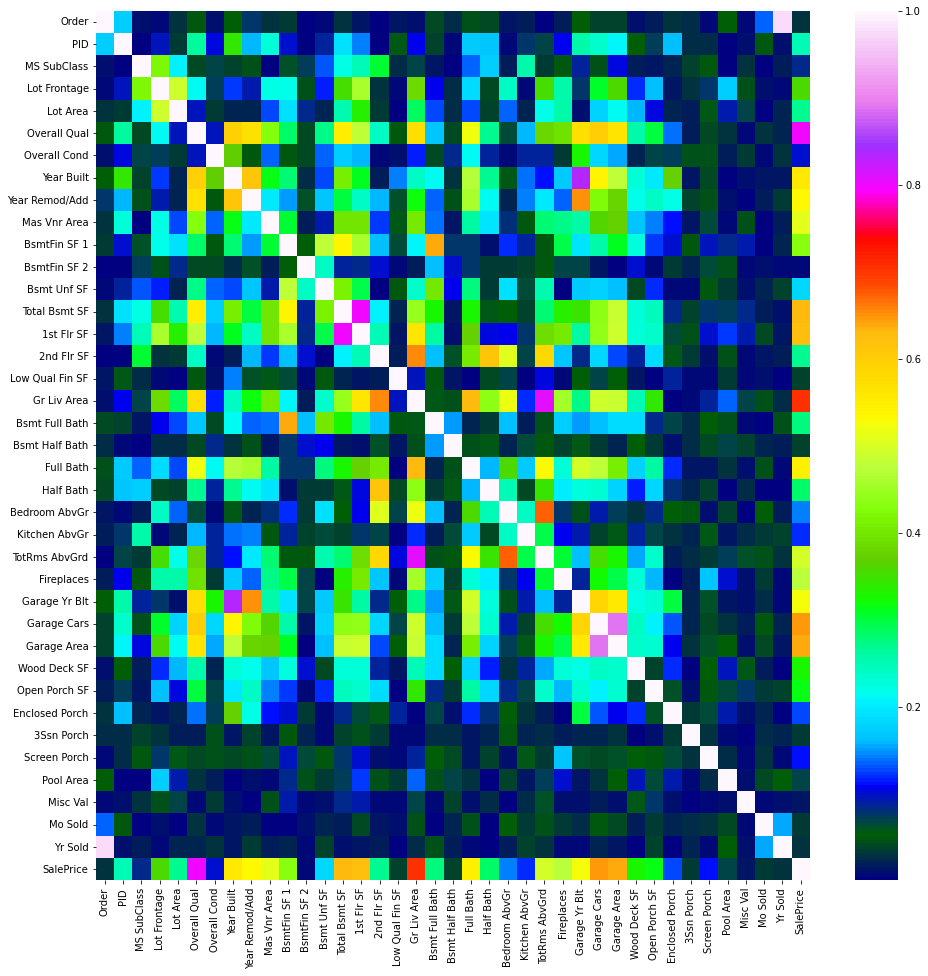

In [4]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(abs(df.corr()),cmap='gist_ncar')
plt.show()

In [5]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Overall Qual','SalePrice']]

def train_and_test(df):
    # split 50:50
    train = df[:1460].copy()
    test = df[1460:].copy()
    
    # numeric
    numeric_train = train.select_dtypes(include=['integer','float'])
    numeric_test = test.select_dtypes(include=['integer','float'])
    
    # train
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    return rmse

# lets create a pipeline function, so  we can just replace names of the input functions to test out the new changes
def pipeline(df=df, t=transform_features, s=select_features, r=train_and_test):
    transform = t(df)
    selected = s(transform)
    rmse = r(selected)
    return rmse
pipeline()

49492.23698000454

# update column cleaning (include dropping text cols)

In [6]:
def transform_features2(df):
    
    # VERSION 2 change: (handling null values in text):   
    null_count = (df.isnull().sum() / len(df))
    df = df[null_count[null_count<0.05].index]
    df = df.fillna(df.select_dtypes(include=['integer','float']).mean())
    
    null_count = df.select_dtypes(include=['object']).isnull().sum()
    textic2_drop = null_count[null_count > 0].index
    df = df.drop(textic2_drop,axis=1) 

    # lets create an age column and filter out rows with negative value:
    df['age'] = df['Yr Sold'] - df['Year Built']
    df = df[df['age'] >= 0]
    
    # lets create a yrs remod column and filter out rows with negative value: 
    df['yrs remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df[df['yrs remod'] >= 0]
   
    # drop the year cols:
    df = df.drop(["Year Built", "Year Remod/Add", 'Yr Sold', 'PID', "Order", 'Sale Type', 'Sale Condition',"Mo Sold"], axis = 1)
    return df



# test different feature selection algos

In [32]:
# transform based on corr matrix:
def select_features2(df):
    abs_corr_coeffs = df.corr()['SalePrice'].abs().sort_values(ascending=False)
    cols = abs_corr_coeffs[abs_corr_coeffs > 0.4].index.tolist()
    df = df[cols]
    return df

pipeline(t=transform_features2,s=select_features2)

36636.25030174907

In [8]:
transformed = transform_features2(df)
%timeit select_features2(transformed)

11.3 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
# transform based on SelectKBest:
def select_features2v2(df):
    numeric_df2 = df.select_dtypes(include=['integer','float'])
    # how many to numeric cols we want to keep?
    numeric_df2 = numeric_df2.drop('SalePrice',axis=1)
    numeric_df2['SalePrice'] = df['SalePrice']
    # how many to numeric cols we want to keep?
    predictors = numeric_df2.columns.tolist()[:-1]
    # Perform feature selection
    selector = SelectKBest(f_classif, k=5)
    selector.fit(numeric_df2[predictors], numeric_df2['SalePrice'])
    # Get the raw p-values for each feature, and transform from p-values into scores
    scores = -np.log10(selector.pvalues_)
    res_frame = pd.DataFrame([predictors,scores]).transpose().sort_values(1,ascending=False)
    res_frame.reset_index(inplace=True)
    res_frame = res_frame.drop('index',axis=1)
    cols = res_frame[0][:14].values.tolist()
    df2 = numeric_df2[cols].copy()
    df2['SalePrice'] = df['SalePrice']
    return df2

pipeline(t=transform_features2,s=select_features2v2)

36669.91992387276

In [10]:
transformed = transform_features2(df)
%timeit select_features2v2(transformed)

147 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Observations:**

The difference in results is very small, we'll choose the first solution. It delivers slightly better results and does that with **only 3 lines of code and 10 times faster.**


# update select features

In [11]:
def col_dummy(df, col):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes
    hood_series = pd.get_dummies(df[col],prefix=col)
    df = pd.concat([df, hood_series], axis=1)
    df = df.drop(columns=(col), axis=1)
    return df

In [12]:
categorical_no_leaks = [ "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature"]

categorical_no_leaks2 = []
for col in categorical_no_leaks:
    # adjust to 8
    if (col in df.columns) & (df[col].value_counts().shape[0]>10):
        categorical_no_leaks2.append(col)


def select_features3(df, corr=0.4):
    abs_corr_coeffs = df.corr()['SalePrice'].abs().sort_values(ascending=False)
    # adjust this one to 0.1:
    cols = abs_corr_coeffs[abs_corr_coeffs > corr].index.tolist()
    df2 = df[cols].copy()
    for col in categorical_no_leaks2:
        if col in df.columns:
            df2[col] = df[col]
            df2 = col_dummy(df2,col)
            

    return df2

pipeline(t=transform_features2,s=select_features3)

32885.6040324598

# update train and test

In [13]:
def train_and_test2(df, k=5, r=1):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True, random_state=r)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)

        avg_rmse = np.mean(rmse_values)
        return avg_rmse

    
rmse = pipeline(t=transform_features2,s=select_features3, r=train_and_test2)
rmse    


29327.856878951097

# Improving results 

In [14]:
def spines(ax,yl='RMSE',xl='Random seed'):
    x1 = ax.spines['right'].set_visible(False)
    x2 = ax.spines['top'].set_visible(False)
    x3 = ax.spines['left'].set_linewidth(2)
    x4 = ax.spines['bottom'].set_linewidth(2)
    x5 = ax.set_ylabel(yl)
    x6 = ax.set_xlabel(xl)
    return x1, x2, x3, x4, x5, x6

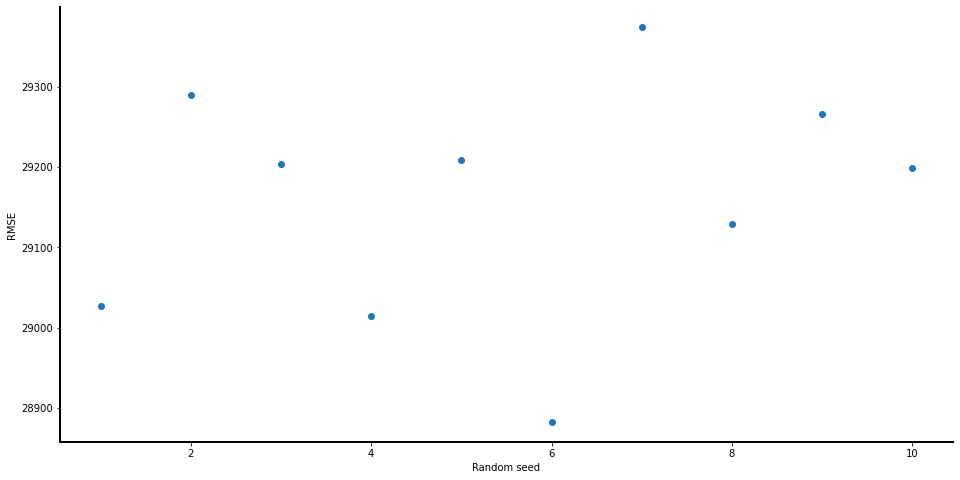

Average rmse result of 100 random seeds:  29159.78662287094
which equals to:  16.12855203363485  percent of avg house price in the original dataset


In [15]:
transform_df = transform_features2(df)
filtered_df = select_features3(transform_df)
k_fold_random1 = []
n_list = list(range(1,11))

for n in n_list:
    rmse = train_and_test2(filtered_df, k=10, r=n)
    k_fold_random1.append(rmse)

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(n_list, k_fold_random1)
spines(ax)
plt.show()

print('Average rmse result of 100 random seeds: ',np.mean(k_fold_random1))
print('which equals to: ', 
      np.mean(k_fold_random1)/ df['SalePrice'].mean() *100,' percent of avg house price in the original dataset')


# Remove outliers
IQR or Z score
[link](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)

https://www.kaggle.com/c/home-data-for-ml-course/discussion/100526#652503

In [16]:
abs(df.corr()['SalePrice']).sort_values(ascending=False)[:35]

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
PID                0.246521
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Enclosed Porch     0.128787
Kitchen AbvGr      0.119814
Screen Porch       0.112151
Overall Cond       0.101697
MS SubClass        0.085092
Pool Area          0.068403
Low Qual Fin SF    0.037660
Bsmt Half Bath     0.035835
Mo Sold            0.035259
3Ssn Porch         0.032225
Name: SalePrice, dty

# Feature engineering
At this stage we'll commence an art of subtle engineering, the best guidance I've found online is a [post](https://towardsdatascience.com/feature-engineering-and-ensembled-models-for-the-top-10-in-kaggle-housing-prices-competition-efb35828eef0) made by one of the top kagglers. To quote a very important section from his post:

>Combining data / simplifying the model — that’s what I use a lot. The world is not that complicated. In this case, it seems to me that 3 features would be enough — how big the house is?, how nice it is? how comfortable is it?

Combining data seems like an easy option for now - lets try it. We'll merge columns in different ways, for now lets start with an easy merging of features and their quality. We can see a repetitive pattern in some columns:
* numeric column with amount(or area) of features (say number of kitchens)
* categorical column with quality of features (quality scale: 'Po', 'Fa', 'TA', 'Gd', 'Ex')
* we'll transform the quality column into numbers and multiply it by amount of features
    * while doing that will raise the quality number to a power of our own deciding

In [17]:
# df = pd.read_csv('AmesHousing.tsv', delimiter="\t")

In [18]:
def quality_area(data2,phrase,col1,col2, weight):
    phrase_cols = [col for col in data2.columns if phrase in col]
    data2['quality'] = data2[col1].map({None: 1, "Po": 2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    data2.loc[data2["quality"].isnull(), "quality"] = 1
    data2[phrase+'_all'] = data2[col2] * (data2["quality"]**weight)
    data2 = data2.drop(columns=phrase_cols+["quality"], axis=1)
    return data2

dff=df.copy()

# 1. fireplace
df_q1 = quality_area(dff,'Fireplace','Fireplace Qu','Fireplaces',5)
# 2. kitchen:
df_q1 = quality_area(df_q1,'Kitchen','Kitchen Qual','Kitchen AbvGr',10)
# 3. garage
df_q1 = quality_area(df_q1,'Garage','Garage Cond','Garage Area',1)
# 4. pool and... - lets try adding one more column to 'Pool_all' column
df_q1 = quality_area(df_q1,'Pool','Pool QC','Pool Area',1)
df_q1['Pool_all'] = df_q1['Pool_all']+df_q1['Misc Val']
df_q1 = df_q1.drop(columns=['Misc Val'])

#########
# df_q1['livin_qa'] = df_q1['Gr Liv Area'] * (df_q1["Overall Qual"])
# df_q1= df_q1.drop(columns=['Gr Liv Area', "Overall Qual"], axis=1)
###########

rmse = pipeline(df=df_q1,t=transform_features2,s=select_features3, r=train_and_test2)
rmse  

28147.243979719664

In [19]:
def merging_data(cols_list):
    d_list = []
    for el in cols_list:
        d = df_q2.groupby(el)['SalePrice'].mean().sort_values().to_dict()
        d_list.append(d)
    return d_list, cols_list

df_q2 = df_q1.copy()


# Roof: 
dl,dl1 = merging_data(['Roof Style', 'Roof Matl'])
df_q2['roofs'] = df_q2['Roof Style'].map(dl[0]) + df_q2['Roof Matl'].map(dl[1])**2

# street: 
dl,dl2 = merging_data(['Street', 'Alley', 'Paved Drive'])
df_q2['streets'] = df_q2['Street'].map(dl[0]) + df_q2['Alley'].map(dl[1]) + df_q2['Paved Drive'].map(dl[2])

# basement:
dl,dl3 = merging_data(['Bsmt Qual','Bsmt Exposure','Bsmt Cond'])
df_q2['base_all'] = (df_q2['Bsmt Qual'].map(dl[0]) + df_q2['Bsmt Exposure'].map(dl[1]) + df_q2['Bsmt Cond'].map(dl[2]))

# exterior:
dl,dl4 = merging_data(['Exter Qual', 'Exter Cond', 'Exterior 1st', 'Exterior 2nd', 
                            'Mas Vnr Type', 'Foundation'])
df_q2['exterior'] = (df_q2['Exter Qual'].map(dl[0])*2 + df_q2['Exter Cond'].map(dl[1]) + df_q2['Exterior 1st'].map(dl[2]) 
+ df_q2['Exterior 2nd'].map(dl[3]) + df_q2['Foundation'].map(dl[5])) * df_q2['Mas Vnr Area'] + df_q2['Mas Vnr Type'].map(dl[4]) 

# heating, AC
dl, dl5 = merging_data(['Heating', 'Heating QC', 'Central Air'])
df_q2['heating'] = df_q2['Heating'].map(dl[0]) + df_q2['Heating QC'].map(dl[1]) + df_q2['Central Air'].map(dl[2])



df_q2 = df_q2.drop(columns=dl1 + dl2 + dl3 + dl4 + dl5 + ['Mas Vnr Area'])

rmse = pipeline(df=df_q2,t=transform_features2,s=select_features3, r=train_and_test2)
rmse  

26810.950967747893

Index(['SalePrice', 'hood_price', 'livin_qa', 'base_all', 'Total Bsmt SF',
       'Garage_all', 'Kitchen_all', 'exterior', 'age', 'yrs remod',
       'Fireplace_all', 'bath_count', 'TotRms AbvGrd', 'heating',
       'BsmtFin SF 1', 'MS SubClass_0', 'MS SubClass_1', 'MS SubClass_2',
       'MS SubClass_3', 'MS SubClass_4', 'MS SubClass_5', 'MS SubClass_6',
       'MS SubClass_7', 'MS SubClass_8', 'MS SubClass_9', 'MS SubClass_10',
       'MS SubClass_11', 'MS SubClass_12', 'MS SubClass_13', 'MS SubClass_14',
       'MS SubClass_15', 'Neighborhood_0', 'Neighborhood_1', 'Neighborhood_2',
       'Neighborhood_3', 'Neighborhood_4', 'Neighborhood_5', 'Neighborhood_6',
       'Neighborhood_7', 'Neighborhood_8', 'Neighborhood_9', 'Neighborhood_10',
       'Neighborhood_11', 'Neighborhood_12', 'Neighborhood_13',
       'Neighborhood_14', 'Neighborhood_15', 'Neighborhood_16',
       'Neighborhood_17', 'Neighborhood_18', 'Neighborhood_19',
       'Neighborhood_20', 'Neighborhood_21', 'Neighborhoo

In [20]:
df_q3 = df_q2.copy()
# bathrooms:
df_q3['bath_count'] = df_q3['Full Bath']**3 + (df_q3['Half Bath']) 
df_q3 = df_q3.drop(columns=['Full Bath', 'Half Bath'], axis=1)

# porch
porch_cols = [col for col in df_q3.columns if 'Porch' in col]
df_q3['total_porch'] = df_q3[porch_cols].sum(axis=1) + df_q3['Wood Deck SF']
df_q3= df_q3.drop(columns=porch_cols+['Wood Deck SF'], axis=1)

rmse = pipeline(df=df_q3,t=transform_features2,s=select_features3, r=train_and_test2)
rmse

26704.639100627413

In [127]:
df_q4 = df_q3.copy()

# LEAK (remember to remove these!!!)
df_q4['usd_per_m2'] = df_q4['SalePrice'] / df_q4['Gr Liv Area']
df_q4['land_usd'] = df_q4['SalePrice']/ df_q4['Lot Area']

def merging_data2(cols_list):
    d_list = []
    for el in cols_list:
        d = df_q4.groupby(el)['land_usd'].mean().sort_values().to_dict()
        d_list.append(d)
    return d_list, cols_list

# Neighborhood:
d7 = df_q4.groupby('Overall Qual')['usd_per_m2'].mean().sort_values().to_dict()
d8 = df_q4.groupby('Neighborhood')['usd_per_m2'].mean().sort_values().to_dict()
################ binning  us per m2 per area:
bins = df_q4['Gr Liv Area'].value_counts(bins=10).index
dmap = df_q4.groupby(pd.cut(df_q4['Gr Liv Area'], bins=bins))['usd_per_m2'].mean()
df_q4['hood_price'] = (df_q4['Gr Liv Area'].map(dmap)**2 + df_q4['Overall Qual'].map(d7) + df_q4['Neighborhood'].map(d8)**2) *  df_q4['Gr Liv Area'] 
df_q4['hood_price'] = df_q4['hood_price']/1000



df_q4= df_q4.drop(columns=['usd_per_m2', 'land_usd'], axis=1)
df_q4= df_q4.drop(columns=['Utilities', 'Condition 1','Bldg Type', 'BsmtFin SF 2','Bsmt Unf SF', 'Bsmt Full Bath',
                          'Bsmt Half Bath', 'BsmtFin Type 1', 'BsmtFin Type 2'], axis=1)


# This one can initaly give us better results: (but once we do iqr its going to be worse!)
# df_q4['livin_qa_ver2'] = df_q4['Gr Liv Area'] + (df_q4["Overall Qual"]**5)

df_q4['livin_qa'] = df_q4['Gr Liv Area'] * (df_q4["Overall Qual"])
df_q4 = df_q4.drop(columns=['Gr Liv Area',"Overall Qual"], axis=1)

transform_df = transform_features2(df_q4)
filtered_df = select_features3(transform_df, corr=0.1)
rmse = train_and_test2(filtered_df, k=4)
rmse


24994.15969916754

In [128]:
# again, IQR will make it better:

lot_cols = [col for col in df_q4.columns if 'Lot' in col]
lot_cols.pop(1)
lot_cols.pop(0)
df_q4= df_q4.drop(columns=lot_cols+['Fence'], axis=1)

land_cols = [col for col in df_q4.columns if 'Land' in col]
dl,dl6 = merging_data(land_cols)
df_q4['land_all'] = df_q4[land_cols[0]].map(dl[0]) + df_q4[land_cols[1]].map(dl[1])
df_q4= df_q4.drop(columns=land_cols, axis=1)

df_q4= df_q4.drop(columns=['1st Flr SF', '2nd Flr SF'], axis=1)


transform_df = transform_features2(df_q4)
filtered_df = select_features3(transform_df, corr=0.1)
rmse = train_and_test2(filtered_df, k=4)
rmse

25402.26764360711

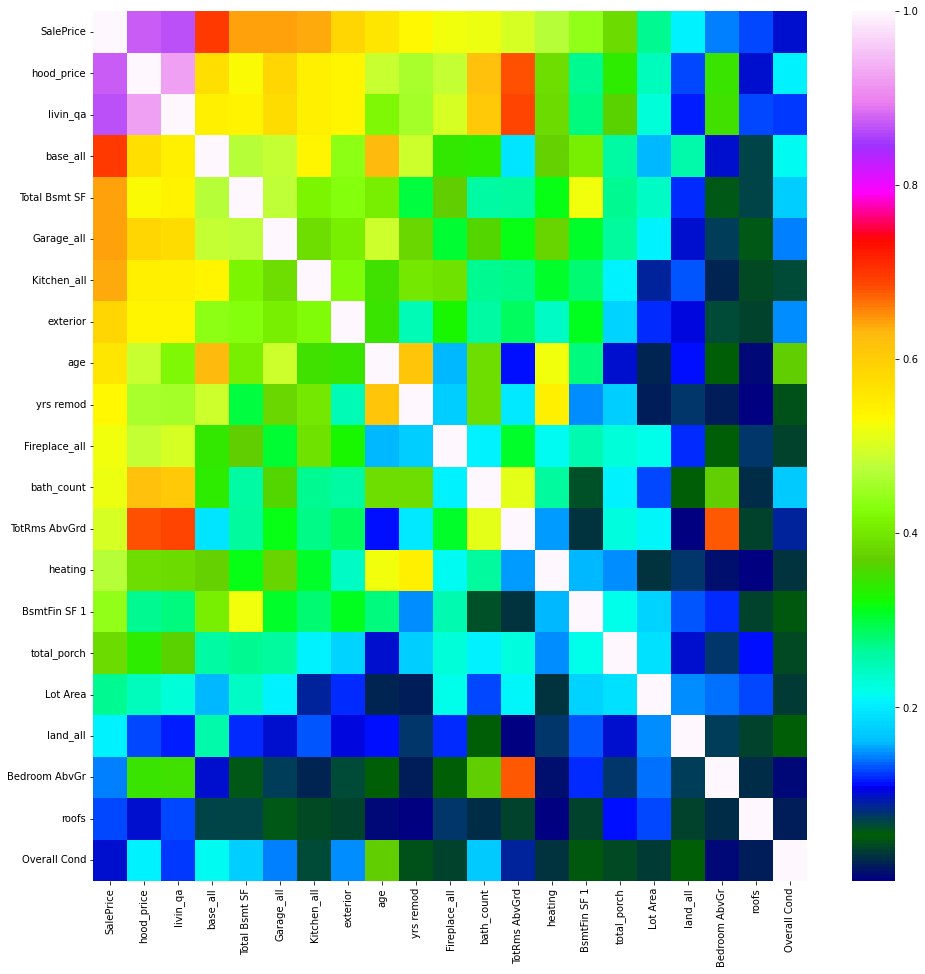

In [129]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(abs(filtered_df.iloc[:,:21].corr()),cmap='gist_ncar')
plt.show()

In [130]:
#23240

In [131]:
# df_q3['land_usd'] = df_q2['SalePrice']/ df_q2['Lot Area']
abs(filtered_df.corr()['SalePrice']).sort_values(ascending=False)[:35]

SalePrice          1.000000
hood_price         0.872469
livin_qa           0.863692
base_all           0.699179
Total Bsmt SF      0.643601
Garage_all         0.643596
Kitchen_all        0.640099
exterior           0.587266
age                0.558979
yrs remod          0.534985
Fireplace_all      0.519922
bath_count         0.519077
TotRms AbvGrd      0.498574
heating            0.470944
BsmtFin SF 1       0.438928
Neighborhood_19    0.433238
total_porch        0.385487
MS SubClass_5      0.362196
Neighborhood_18    0.295117
Lot Area           0.267520
Neighborhood_25    0.239100
MS SubClass_1      0.234853
Neighborhood_20    0.211880
land_all           0.206005
Neighborhood_15    0.188526
MS SubClass_4      0.178820
Neighborhood_11    0.174606
Neighborhood_7     0.167395
Neighborhood_24    0.157720
Bedroom AbvGr      0.143916
Neighborhood_3     0.137209
Neighborhood_26    0.130845
Neighborhood_22    0.128480
roofs              0.126232
Neighborhood_13    0.120385
Name: SalePrice, dty

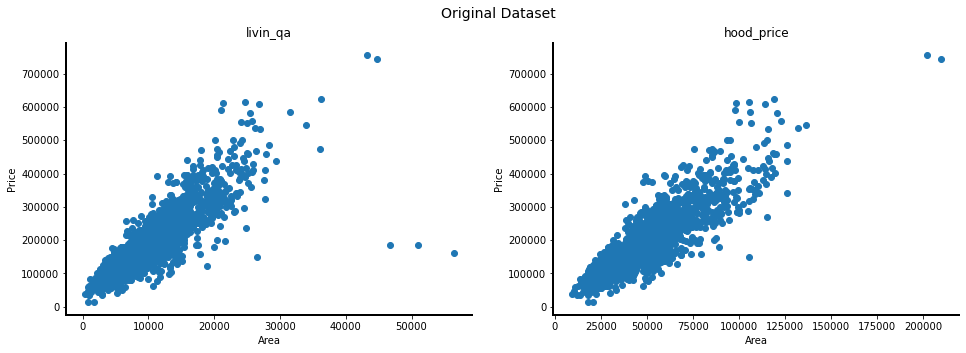

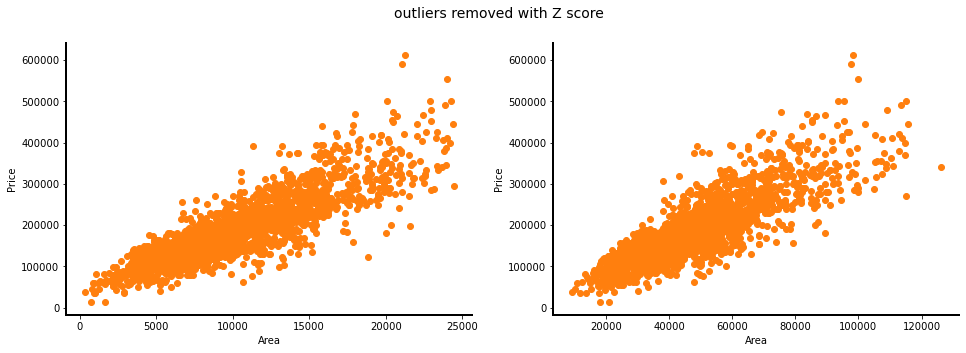

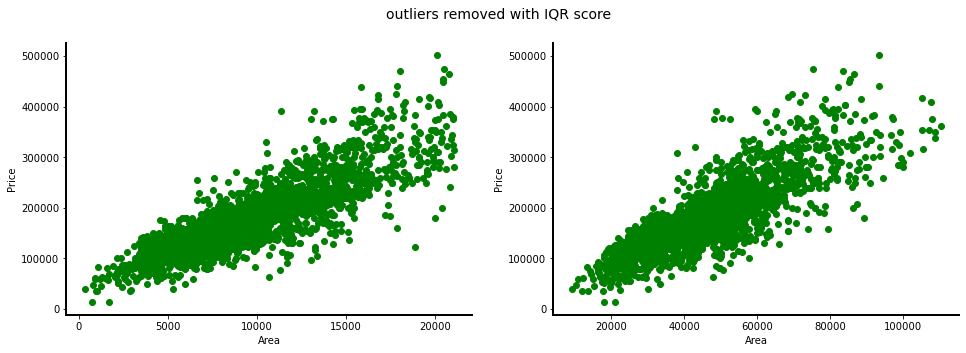

In [132]:
from scipy import stats
# Z score
z = np.abs(stats.zscore(df_q4['livin_qa']))
threshold = 3
np.where(z > 3)
df_test1 = df_q4[(z < 3)]

# IQR method:
Q1 = df_q4["livin_qa"].quantile(0.25)
Q3 = df_q4["livin_qa"].quantile(0.75)
IQR = Q3 - Q1
df_test2 = df_q4[~((df_q4["livin_qa"] < (Q1 - 1.5 * IQR)) |(df_q4["livin_qa"] > (Q3 + 1.5 * IQR)))]

fig, ax = plt.subplots(1,2,figsize=(16,5))
fig.suptitle('Original Dataset', size=14)
ax1 = plt.subplot(121)
plt.scatter(df_q4["livin_qa"], df_q4["SalePrice"])
plt.title("livin_qa")
ax2 = plt.subplot(122)
plt.scatter(df_q4["hood_price"], df_q4["SalePrice"])
plt.title("hood_price")
fig, ax = plt.subplots(1,2,figsize=(16,5))
fig.suptitle('outliers removed with Z score', size=14)
ax3 = plt.subplot(121)
plt.scatter(df_test1["livin_qa"], df_test1["SalePrice"], c='#ff7f0e')
ax4 = plt.subplot(122)
plt.scatter(df_test1["hood_price"], df_test1["SalePrice"], c='#ff7f0e')

fig, ax = plt.subplots(1,2,figsize=(16,5))
fig.suptitle('outliers removed with IQR score', size=14)

ax5 = plt.subplot(121)
plt.scatter(df_test2["livin_qa"], df_test2["SalePrice"], c='green')
ax6 = plt.subplot(122)
plt.scatter(df_test2["hood_price"], df_test2["SalePrice"], c='green')

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    spines(ax,xl='Area', yl='Price')

plt.show()

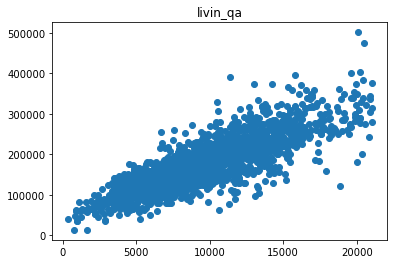

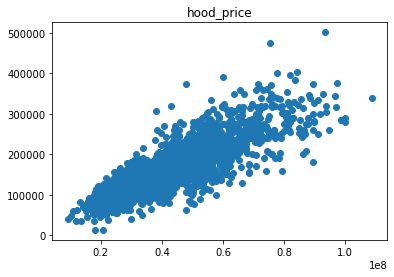

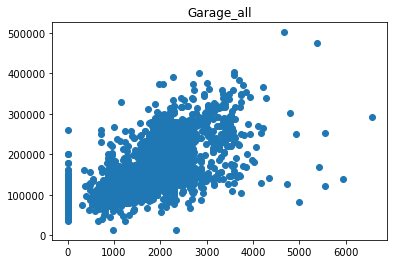

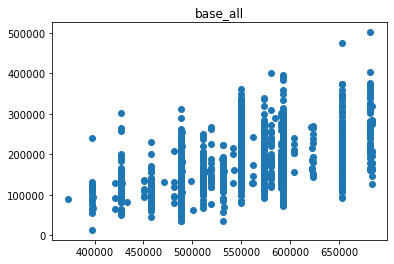

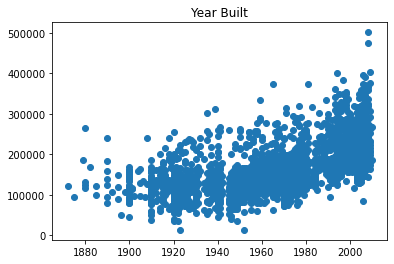

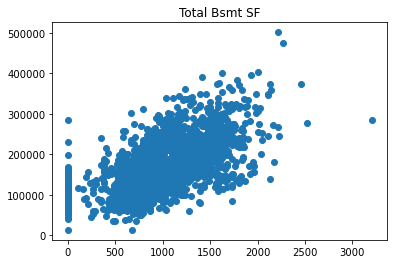

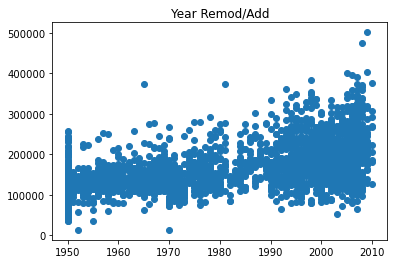

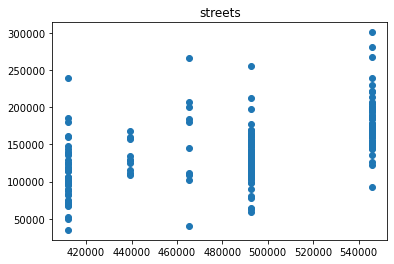

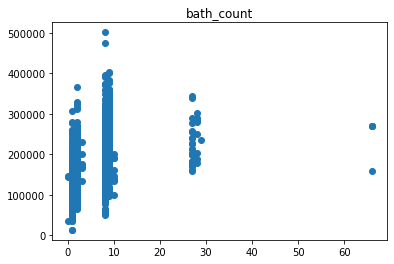

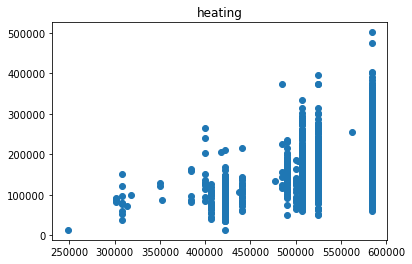

In [133]:
# df_q3['lot_all'] = df_q2['SalePrice']/ df_q2['Lot Area']
top10_corrs = abs(df_3iqr.corr()['SalePrice']).sort_values(ascending=False)[1:11].index.tolist()
for el in top10_corrs:
    plt.scatter(df_3iqr[el], df_3iqr["SalePrice"])
    plt.title(el)
    plt.show()

In [206]:
def iqring(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df2 = df[~((df[col] < (Q1 - 1.5 * IQR)) |(df[col] > (Q3 + 1.5 * IQR)))]
    return df2

df_2iqr = iqring(df_q4, 'livin_qa')
df_3iqr = iqring(df_2iqr, 'base_all')

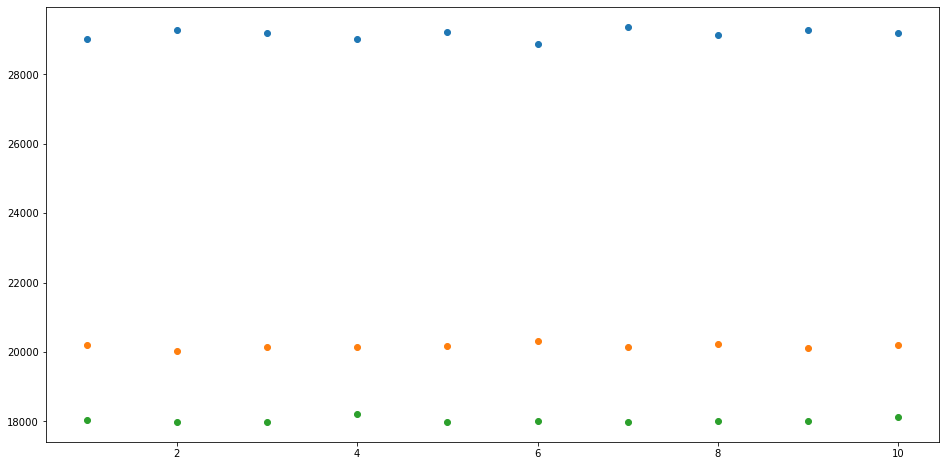

Average rmse result of 100 random seeds:  29159.78662287094
which equals to:  16.12855203363485  percent of avg house price in the original dataset
 
Average rmse result of 100 random seeds Z score method:  20164.317680462547
which equals to:  11.153073619441445  percent of avg house price in the original dataset
 
Average rmse result of 100 random seeds IQR score method:  18038.131240876144
which equals to:  9.97705991716073  percent of avg house price in the original dataset


In [207]:
from scipy import stats
# Z score:
transform_df = transform_features2(df_test1)
filtered_df = select_features3(transform_df, corr=0.01)
k_fold_random2 = []
percent_er2 = []
n_list = list(range(1,11))
for n in n_list:
    rmse = train_and_test2(filtered_df, k=10, r=n)
    k_fold_random2.append(rmse)
    percent_er2.append(rmse/df["SalePrice"].mean() *100)
np.mean(k_fold_random2)

# IQR:
transform_df = transform_features2(df_3iqr)
filtered_df = select_features3(transform_df, corr=0.01)
k_fold_random3 = []
percent_er3 = []
n_list = list(range(1,11))
for n in n_list:
    rmse = train_and_test2(filtered_df, k=10, r=n)
    k_fold_random3.append(rmse)
    percent_er3.append(rmse/df["SalePrice"].mean() *100)
np.mean(k_fold_random3)

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(n_list, k_fold_random1, label='Original dataset')
plt.scatter(n_list, k_fold_random2, label='Z score aplied')
plt.scatter(n_list, k_fold_random3, label='IQR score aplied')
plt.show()

print('Average rmse result of 100 random seeds: ',np.mean(k_fold_random1))
print('which equals to: ', 
      np.mean(k_fold_random1)/ df['SalePrice'].mean() *100,' percent of avg house price in the original dataset')
print(' ')
print('Average rmse result of 100 random seeds Z score method: ',np.mean(k_fold_random2))
print('which equals to: ', 
      np.mean(k_fold_random2)/ df['SalePrice'].mean() *100,' percent of avg house price in the original dataset')
print(' ')
print('Average rmse result of 100 random seeds IQR score method: ',np.mean(k_fold_random3))
print('which equals to: ', 
      np.mean(k_fold_random3)/ df['SalePrice'].mean() *100,' percent of avg house price in the original dataset')



In [208]:
len(df_3iqr)
#18884 - 2736
# 18588 - 2705

2705

In [209]:
#19249 - 1 column

In [210]:
#19819



# Apply log-transfomation (log(1+x))


In [211]:

# # IQR best so far
# df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
# df["SalePrice"] = np.log1p(df["SalePrice"])
# #

# Q1 = df["Gr Liv Area"].quantile(0.25)
# Q3 = df["Gr Liv Area"].quantile(0.75)
# IQR = Q3 - Q1
# # print(IQR)
# # (df["Gr Liv Area"] < (Q1 - 1.5 * IQR)) |(df["Gr Liv Area"] > (Q3 + 1.5 * IQR))
# df_test2 = df[~((df["Gr Liv Area"] < (Q1 - 1.5 * IQR)) |(df["Gr Liv Area"] > (Q3 + 1.5 * IQR)))]
# # df = test_iqr

# rmse = pipeline(df=df_test2,t=transform_features2,s=select_features3, r=train_and_test2)

# print(rmse)
# # fig, ax = plt.subplots(figsize=(16,8))
# # plt.scatter(test_iqr["Gr Liv Area"], test_iqr["SalePrice"])
# # plt.show()
# print(len(df_test2))
# # check the percentage error for INITAL DATASET not the new one
# print(rmse/df["SalePrice"].mean() *100, ' percent of avg price')


# fig, ax = plt.subplots(2,2,figsize=(16,8))

# ax = plt.subplot(221)
# plt.scatter(df_test2["Gr Liv Area"], df_test2["SalePrice"])
# ax = plt.subplot(222)
# plt.scatter(df_test2["Total Bsmt SF"], df_test2["SalePrice"])
# ax = plt.subplot(223)
# plt.scatter(df_test2["Garage Area"], df_test2["SalePrice"])
# ax = plt.subplot(224)
# plt.scatter(df_test2["1st Flr SF"], df_test2["SalePrice"])

# plt.show()

In [212]:
def train_and_test3(df, k=5, r=1):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True, random_state=r)
        rmse_values = []
        df_list = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            test2 = test.copy()
            test2['predicted'] = predictions
            df_list.append(test2)
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)

        avg_rmse = np.mean(rmse_values)
        return avg_rmse, df_list

    
rmse = pipeline(t=transform_features2,s=select_features3, r=train_and_test2)
rmse    



29327.856878951097

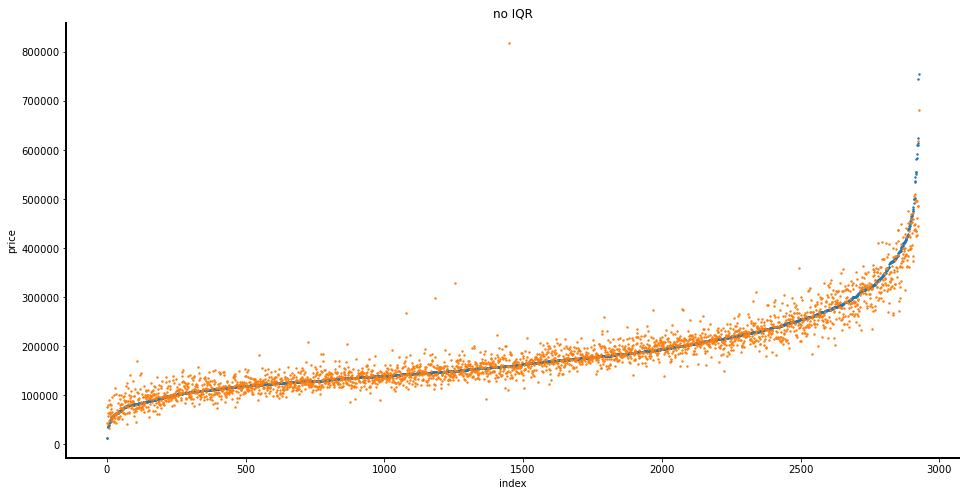

In [213]:
transform_df = transform_features2(df_q4)
filtered_df = select_features3(transform_df, corr=0.1)
rmse, df_list = train_and_test3(filtered_df, k=4)

res_df = pd.concat(df_list, axis=0)
res_df = res_df.sort_values('SalePrice')
res_df = res_df.reset_index()
res_df = res_df.drop(columns='index')
res_df

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(res_df.index, res_df['SalePrice'], s=2)
plt.scatter(res_df.index, res_df['predicted'], s=2)
spines(ax,yl='price',xl='index')
plt.title('no IQR')
plt.show()

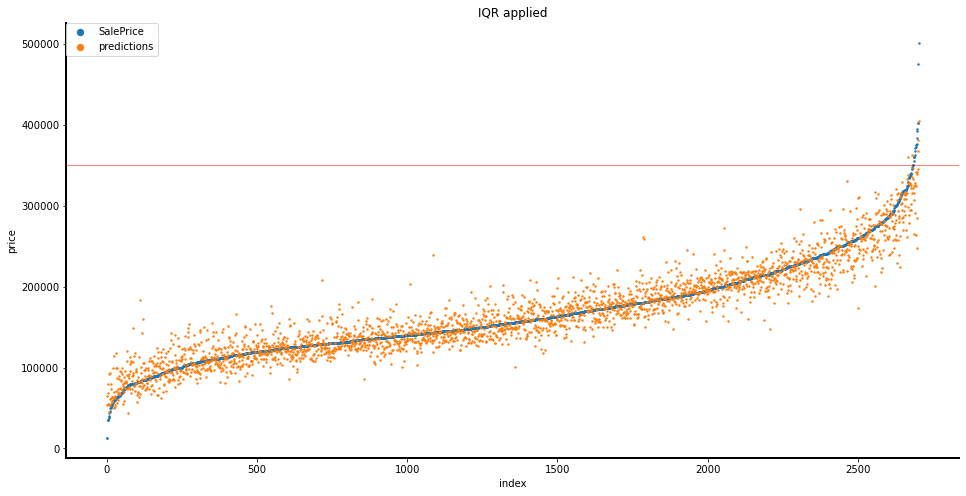

In [214]:
transform_df = transform_features2(df_3iqr)
filtered_df = select_features3(transform_df, corr=0.1)
rmse, df_list = train_and_test3(filtered_df, k=4)

res_df = pd.concat(df_list, axis=0)
res_df = res_df.sort_values('SalePrice')
res_df = res_df.reset_index()
res_df = res_df.drop(columns='index')

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(res_df.index, res_df['SalePrice'], s=2, label='SalePrice')
plt.scatter(res_df.index, res_df['predicted'], s=2, label='predictions')
spines(ax,yl='price',xl='index')
plt.axhline(350000, c='r', linewidth=0.5)

# legend points to small? solution:
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles, labels, loc=2, borderaxespad=0)
for el in l.legendHandles:
    el._sizes = [40]
plt.title('IQR applied')
plt.show()

In [215]:
res_df.columns

Index(['SalePrice', 'livin_qa', 'hood_price', 'Garage_all', 'age', 'base_all',
       'Total Bsmt SF', 'yrs remod', 'bath_count', 'heating', 'Kitchen_all',
       'exterior', 'TotRms AbvGrd', 'Fireplace_all', 'BsmtFin SF 1',
       'total_porch', 'Lot Area', 'Bedroom AbvGr', 'land_all', 'MS SubClass_0',
       'MS SubClass_1', 'MS SubClass_2', 'MS SubClass_3', 'MS SubClass_4',
       'MS SubClass_5', 'MS SubClass_6', 'MS SubClass_7', 'MS SubClass_8',
       'MS SubClass_9', 'MS SubClass_10', 'MS SubClass_11', 'MS SubClass_12',
       'MS SubClass_13', 'MS SubClass_14', 'MS SubClass_15', 'Neighborhood_0',
       'Neighborhood_1', 'Neighborhood_2', 'Neighborhood_3', 'Neighborhood_4',
       'Neighborhood_5', 'Neighborhood_6', 'Neighborhood_7', 'Neighborhood_8',
       'Neighborhood_9', 'Neighborhood_10', 'Neighborhood_11',
       'Neighborhood_12', 'Neighborhood_13', 'Neighborhood_14',
       'Neighborhood_15', 'Neighborhood_16', 'Neighborhood_17',
       'Neighborhood_18', 'Neighborhood

In [216]:
res_df['diff'] = abs(res_df['SalePrice'] - res_df['predicted'])
# res_df.sort_values('diff', ascending=False).loc[:100,'Neighborhood_0':]
res_df = res_df.sort_values('diff', ascending=False)
res_df = res_df.reset_index()
res_df = res_df.drop(columns='index')
res_df.loc[:20,'Neighborhood_0':'Neighborhood_27'].sum().sort_values(ascending=False)[:10]

Neighborhood_15    4
Neighborhood_6     3
Neighborhood_7     3
Neighborhood_25    2
Neighborhood_19    2
Neighborhood_5     2
Neighborhood_14    1
Neighborhood_18    1
Neighborhood_17    1
Neighborhood_27    1
dtype: int64

In [289]:
res_df['diff'] = abs(res_df['SalePrice'] - res_df['predicted'])
# res_df.sort_values('diff', ascending=False).loc[:100,'Neighborhood_0':]
res_df = res_df.sort_values('diff', ascending=False)
res_df = res_df.reset_index()
res_df = res_df.drop(columns='index')
res_df.loc[:20,'MS SubClass_0':'MS SubClass_15'].sum().sort_values(ascending=False)[:20]

MS SubClass_0     12
MS SubClass_5      2
MS SubClass_8      2
MS SubClass_1      1
MS SubClass_4      1
MS SubClass_6      1
MS SubClass_10     1
MS SubClass_11     1
MS SubClass_2      0
MS SubClass_3      0
MS SubClass_7      0
MS SubClass_9      0
MS SubClass_12     0
MS SubClass_13     0
MS SubClass_14     0
MS SubClass_15     0
dtype: int64

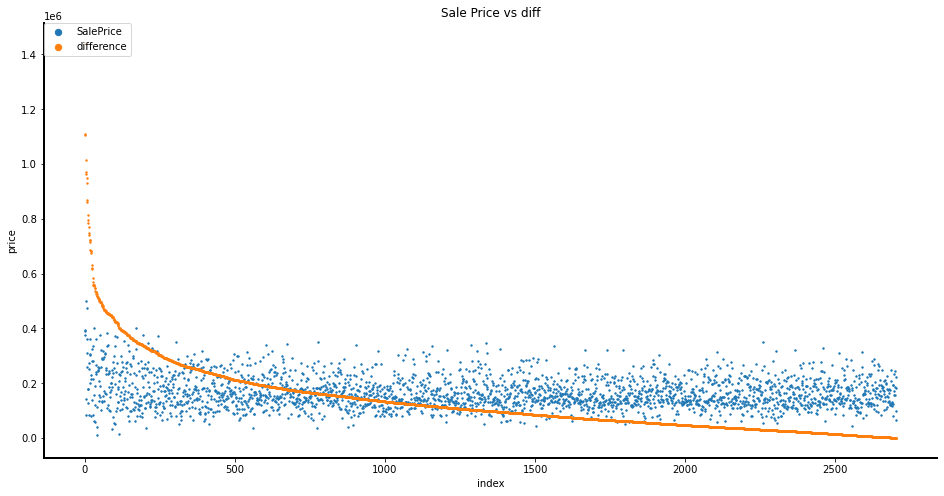

In [290]:
fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(res_df.index, res_df['SalePrice'], s=2, label='SalePrice')
plt.scatter(res_df.index, res_df['diff']*10, s=2, label='difference')
spines(ax,yl='price',xl='index')
# plt.axhline(350000, c='r', linewidth=0.5)

# legend points to small? solution:
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles, labels, loc=2, borderaxespad=0)
for el in l.legendHandles:
    el._sizes = [40]
plt.title('Sale Price vs diff')
plt.show()

In [218]:
res_df[res_df['MS SubClass_0'] == 1]

,SalePrice,livin_qa,hood_price,Garage_all,age,base_all,Total Bsmt SF,yrs remod,bath_count,heating,...,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Neighborhood_25,Neighborhood_26,Neighborhood_27,predicted,diff
0,392000,11352,59931.366031,2268.0,0,593012.478942,1419.0,0,8,584413.461413,...,0,0,0,0,0,1,0,0,247717.171657,144282.828343
2,395000,15784,82068.502241,3580.0,1,593012.478942,1935.0,1,8,524901.920143,...,0,0,0,0,0,0,0,0,284494.144164,110505.855836
3,82500,9877,39164.833693,2176.0,32,487924.445325,1386.0,32,8,507031.726846,...,0,0,0,0,0,0,0,0,184137.646099,101637.646099
4,501837,20106,93366.506217,4664.0,1,681446.364890,2216.0,0,8,584413.461413,...,0,0,0,0,0,1,0,0,404730.087346,97106.912654
5,143000,7365,44113.327993,1808.0,41,591202.273846,1437.0,6,1,584413.461413,...,0,0,0,0,0,0,0,0,239337.225638,96337.225638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,233555,11076,61834.551364,1980.0,0,549803.816318,1836.0,0,8,524901.920143,...,0,0,0,0,0,0,0,0,233643.420653,88.420653
2695,157900,8652,40714.126577,1204.0,49,487924.445325,1442.0,49,2,524901.920143,...,0,0,0,0,0,0,0,0,157814.467132,85.532868
2696,170000,6640,47650.623350,1232.0,48,591202.273846,1350.0,48,2,524901.920143,...,0,0,0,0,0,0,1,0,169934.911923,65.088077
2699,186000,9184,37461.443716,1980.0,50,487924.445325,1312.0,7,2,584413.461413,...,0,0,0,0,0,0,0,0,186034.543577,34.543577


In [219]:
abs(res_df.corr()['diff']).sort_values(ascending=False)[:10]

diff             1.000000
hood_price       0.240745
livin_qa         0.238228
predicted        0.225317
SalePrice        0.223914
Lot Area         0.182063
Fireplace_all    0.175521
TotRms AbvGrd    0.174734
Total Bsmt SF    0.172515
Kitchen_all      0.134358
Name: diff, dtype: float64

In [220]:
abs(res_df[res_df['MS SubClass_0'] == 1].corr()['diff']).sort_values(ascending=False)[:10]

diff               1.000000
hood_price         0.315900
predicted          0.299378
livin_qa           0.295040
SalePrice          0.293075
Neighborhood_25    0.285235
Total Bsmt SF      0.235689
base_all           0.214921
Fireplace_all      0.213319
Lot Area           0.199358
Name: diff, dtype: float64

In [221]:
res_df[['hood_price','livin_qa','diff' ]][:100]['hood_price'].mean()

56970.24622624538

In [222]:
res_df[['hood_price','livin_qa','diff' ]][:100]['hood_price'].mean()

56970.24622624538

In [223]:
res_df['diff'].mean()

13399.874566706854

In [224]:
res_df[:10]['hood_price'].mean()

60776.42288067308

In [225]:
res_df[-10:]['hood_price'].mean()

43662.270580571385

In [226]:
res_df[res_df['MS SubClass_0'] == 1]['hood_price'].mean()

39578.730193523515

In [227]:
res_df[(res_df['MS SubClass_0'] == 1) & (res_df['hood_price'] > 60000)]['diff'].mean()

28354.26210968475

# Idea: multiply the most important sale price factor for MS SubClass_0 , see what happens

In [228]:
res_df[(res_df['hood_price'] > 60000)]['diff'].mean()

20275.594813275475

In [229]:
filtered_df.loc[(filtered_df['MS SubClass_0'] == 1) & (filtered_df['hood_price'] > 60000), 'hood_price'] =+10000 

In [230]:
transform_df = transform_features2(df_3iqr)
filtered_df = select_features3(transform_df, corr=0.1)
rmse, df_list = train_and_test3(filtered_df, k=4)
rmse

18712.45512084958

In [231]:
transform_df = transform_features2(df_3iqr)
filtered_df = select_features3(transform_df, corr=0.1)
filtered_df.loc[(filtered_df['hood_price'] > 50000), 'hood_price'] = filtered_df.loc[(filtered_df['hood_price'] > 50000), 'hood_price'] * 1.5 
rmse, df_list = train_and_test3(filtered_df, k=4)
rmse

18664.123102930607

In [232]:
transform_df = transform_features2(df_3iqr)
filtered_df = select_features3(transform_df, corr=0.1)
filtered_df.loc[(filtered_df['MS SubClass_0'] == 1) & (filtered_df['hood_price'] > 50000), 'hood_price'] = filtered_df.loc[(filtered_df['MS SubClass_0'] == 1) & (filtered_df['hood_price'] > 50000), 'hood_price'] / 10 
rmse, df_list = train_and_test3(filtered_df, k=4)
rmse

18629.970696468685

# simplest solutions are the best:


In [274]:
df_3iqr = iqring(df_2iqr, 'base_all')

In [275]:
transform_df = transform_features2(df_3iqr)
filtered_df = select_features3(transform_df, corr=0.1)
rmse, df_list = train_and_test3(filtered_df, k=4)
print('rmse: ',rmse, ' rows: ',len(df_3iqr))

rmse:  18712.45512084958  rows:  2705


In [284]:
def pipeline3 (df, top_price, low_price):
    df = df[df['SalePrice'] < top_price]
    df = df[df['SalePrice'] > low_price]
    transform_df = transform_features2(df)
    filtered_df = select_features3(transform_df, corr=0.1)
    rmse, df_list = train_and_test3(filtered_df, k=4)
    print('rmse: ',rmse, ' rows: ',len(df))
    return rmse, df_list
rmse, df_list = pipeline3(df_3iqr, 350000, 0)

rmse:  17543.24256588665  rows:  2684


In [285]:
rmse, df_list = pipeline3(df_3iqr, 350000, 40000)

rmse:  17561.821576131704  rows:  2676


In [286]:
rmse, df_list = pipeline3(df_3iqr, 350000, 60000)

rmse:  17351.834687289538  rows:  2657


In [287]:
rmse, df_list = pipeline3(df_3iqr, 350000, 70000)

rmse:  16849.835300720162  rows:  2632


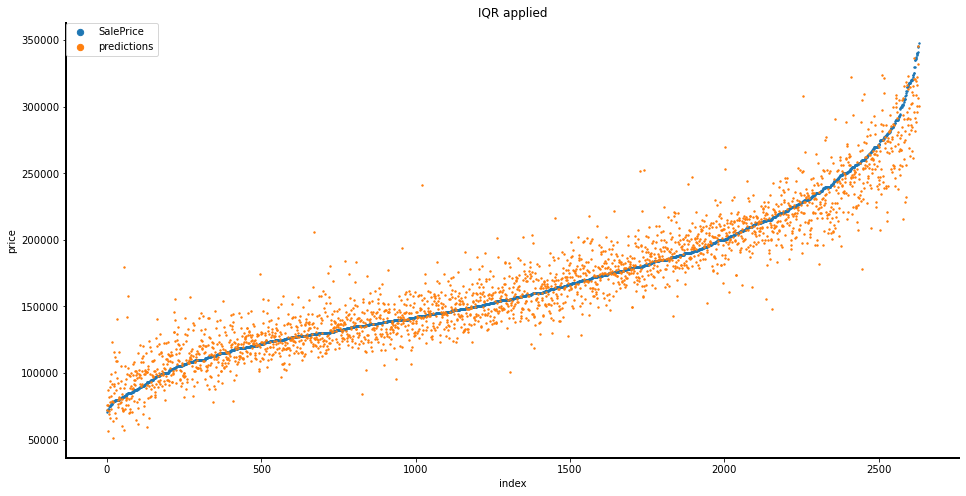

In [292]:
res_df = pd.concat(df_list, axis=0)
res_df = res_df.sort_values('SalePrice')
res_df = res_df.reset_index()
res_df = res_df.drop(columns='index')

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(res_df.index, res_df['SalePrice'], s=2, label='SalePrice')
plt.scatter(res_df.index, res_df['predicted'], s=2, label='predictions')
spines(ax,yl='price',xl='index')
# plt.axhline(350000, c='r', linewidth=0.5)

# legend points to small? solution:
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles, labels, loc=2, borderaxespad=0)
for el in l.legendHandles:
    el._sizes = [40]
plt.title('IQR applied')
plt.show()

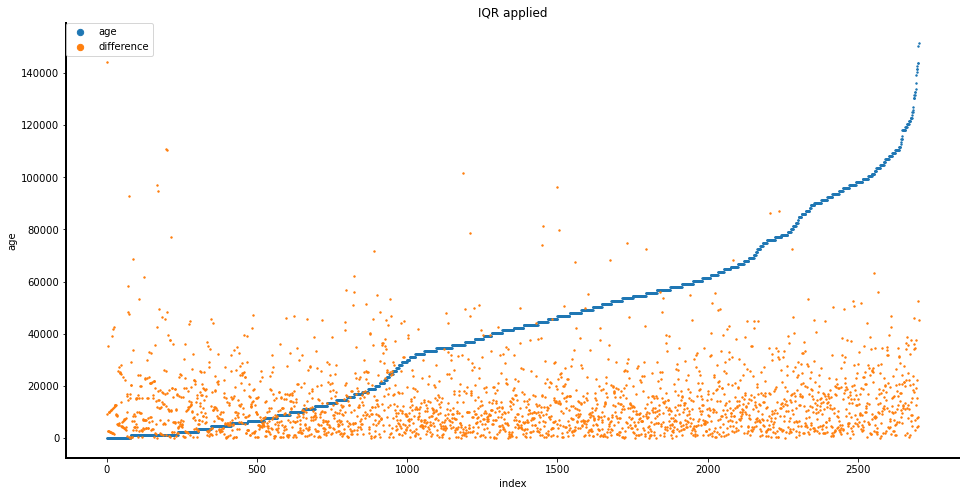

In [237]:
res_df = res_df.sort_values('age')
res_df = res_df.reset_index()
res_df = res_df.drop(columns='index')

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(res_df.index, res_df['age']*1115, s=2, label='age')
plt.scatter(res_df.index, res_df['diff'], s=2, label='difference')
spines(ax,yl='age',xl='index')
# plt.axhline(350000, c='r', linewidth=0.5)

# legend points to small? solution:
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles, labels, loc=2, borderaxespad=0)
for el in l.legendHandles:
    el._sizes = [40]
plt.title('IQR applied')
plt.show()